# CSE2530 Computational Intelligence
## Assignment 3: Reinforcement Learning

<div style="background-color:#f1be3e">

_Fill in your group number **from Brightspace**, names, and student numbers._
    
| Group                   | 65      |
|-------------------------|---------|
| Daniel De Dios          | 5722055 |
| Ignacio Cuñado Barral   | 5716128 |
| Pablo Hendriks Bardaj   | 5790069 |
| Alberto Moreno Sanchez  | 5688078 |

#### Imports

In [1]:
"""
You may only use numpy to implement your algorithms
You can make use of any other libraries for miscellaneous functions, e.g. to create the visual aids.
Put all of your imports in this code block.
"""
import matplotlib.pyplot as plt
import numpy as np
import random
from typing import Dict, List
from tqdm import tqdm

"""
The following classes are fully implemented in their own files and you should not change them.
Nonetheless, we encourage you to check how they work; this will help you get started.
"""
from Agent import Agent
from Maze import Maze
from QTable import QTable
from State import State
from Action import Action

C:\Users\danie\PycharmProjects\dentistry-ai\venv\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\danie\PycharmProjects\dentistry-ai\venv\Lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\danie\PycharmProjects\dentistry-ai\venv\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## 2. Navigating in the Supermarket
### 2.1 Development
#### Question 1

In [2]:
class ExplorationStrategy:
    def __init__(self, q_table: QTable):
        self.q_table = q_table

    def random(self, agent: Agent, maze: Maze):
        """
        The random exploration strategy selects a random action uniformly at random
        from the set of all valid actions.
        """
        valid_actions = agent.get_valid_actions(maze)
        selected_action = random.choice(valid_actions)

        return selected_action

    def e_greedy(self, agent: Agent, maze: Maze, eps: float):
        """
        The e-greedy exploration strategy selects a random action with probability eps,
        and the action with highest q-value with probability 1 - eps. A value of epsilon
        close to 0 favours exploitation, while a value close to 1 favours exploration.
        """
        if random.uniform(0, 1) < eps:
            # Explore
            valid_actions = agent.get_valid_actions(maze)
            selected_action = random.choice(valid_actions)
        else:
            # Exploit
            valid_actions = agent.get_valid_actions(maze)
            valid_actions_ids = [action.id for action in valid_actions]
            
            current_state = agent.get_state(maze)
            q_values = {action_id: self.q_table.q_table[current_state.id][action_id] for action_id in valid_actions_ids}
            
            max_q = max(q_values.values())
            best_actions = [action_id for action_id, q in q_values.items() if q == max_q]
            selected_action_id = random.choice(best_actions)
            selected_action = [action for action in valid_actions if action.id == selected_action_id][0]
    
        return selected_action


    def boltzmann(self, agent: Agent, maze: Maze, temperature: float):
        """
        The Boltzmann exploration strategy assigns a probability to each action based on its estimated q-values.
        A large value of the temperature encourages exploration, and as the temperature declines over time,
        exploitation is favoured. 
        """
        valid_actions = agent.get_valid_actions(maze)
        valid_actions_ids = [action.id for action in valid_actions]
        
        current_state = agent.get_state(maze)
        q_values = {action_id: self.q_table.q_table[current_state.id][action_id] for action_id in valid_actions_ids}
        
        probabilities = np.array([np.exp(q / temperature) for q in q_values.values()])
        probabilities /= probabilities.sum()
        
        selected_action_id = np.random.choice(list(q_values.keys()), p=probabilities)
        selected_action = [action for action in valid_actions if action.id == selected_action_id][0]
    
        return selected_action


<div style="background-color:#f1be3e">

_Put your extra code blocks above (if any) and write your answer here._

#### Question 2

100%|██████████| 300/300 [00:01<00:00, 159.02it/s]


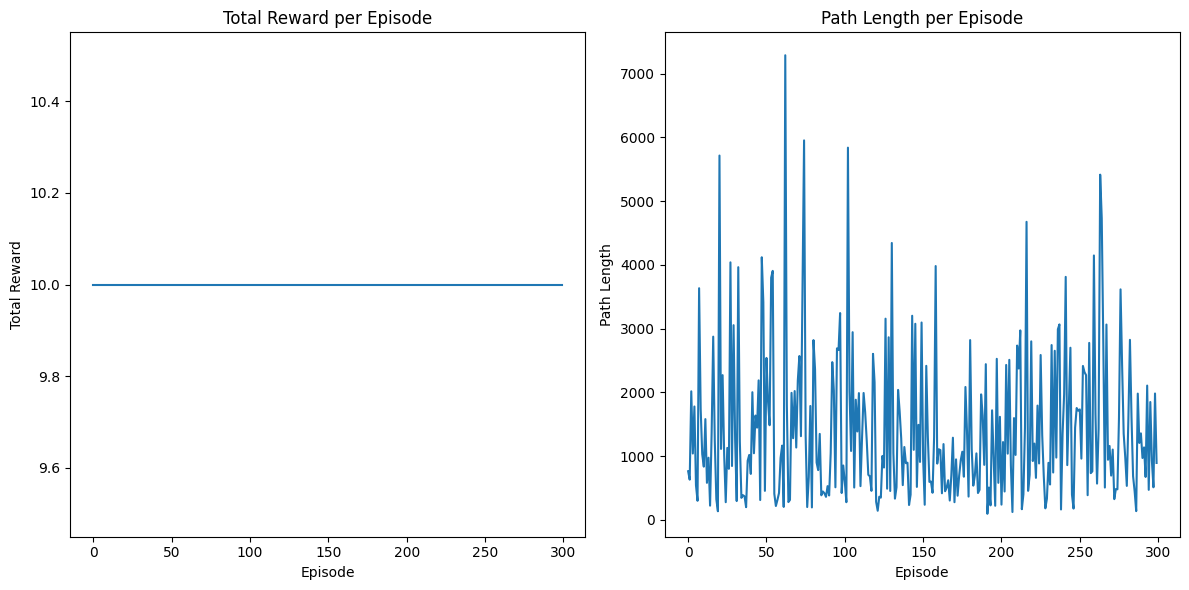

In [36]:
# Create a Maze instance.
maze = Maze("./../data/toy_maze.txt")
maze.set_reward(x=9, y=9, reward=10)
maze.set_terminal(x=9, y=9)
# Create an Agent.
agent = Agent(start_x=0, start_y=0)
# Create a QTable.
states = maze.get_all_states()
actions = [Action(id) for id in ["up", "down", "left", "right"]]
q_table = QTable(states, actions)
# Create an ExplorationStrategy.
exploration_strategy = ExplorationStrategy(q_table)
# Create a learner.
params = {"lr": 0.7, "gamma": 0.9}
#learner = QLearning(q_table, params)


# Hyper-parameters.
n_episodes = 300
episode_lengths = []
episode_rewards = []

def run_learning_episodes_base(maze, agent, exploration_strategy, exploration_strategy_name, n_episodes=300, epsilon = 0.01, temperature=0.2):
    """
    Runs multiple episodes of the reinforcement learning process.

    Parameters:
    - maze: The maze environment.
    - agent: The agent navigating the maze.
    - exploration_strategy: The strategy used by the agent to explore the maze.
    - exploration_strategy_name: The specific exploration strategy to implement in the cycle. 
    - learner: The learning algorithm to update the agent's knowledge.
    - with_learning: Whether the agent should learn from its experiences.
    - n_episodes: The number of episodes to run.
    - temperature: The temperature parameter for the Boltzmann exploration strategy.

    Returns:
    - episode_rewards: A list containing the total reward earned in each episode.
    - episode_lengths: A list containing the number of steps (length of the path) taken in each episode.
    """
    episode_rewards = []
    episode_lengths = []

    for episode in tqdm(range(n_episodes)):
        total_reward = 0
        agent.reset()
        done = False
        steps = 0

        while not done:
            current_state = agent.get_state(maze)
            action = None
            if exploration_strategy_name == "random":
                action = exploration_strategy.random(agent, maze)
            elif exploration_strategy_name == "e-greedy":
                action = exploration_strategy.e_greedy(agent, maze, epsilon)
            elif exploration_strategy_name == "boltzmann":
                action = exploration_strategy.boltzmann(agent, maze, temperature)
            next_state, reward, done = agent.step(action, maze)

            # Update the total reward and steps
            total_reward += reward
            steps += 1

            # Learning
            # if with_learning: 
            #     learner.learn(current_state, action, reward, next_state, done)

        episode_rewards.append(total_reward)
        episode_lengths.append(steps)

    return episode_rewards, episode_lengths

# Example usage
episode_rewards, episode_lengths = run_learning_episodes_base(maze, agent, exploration_strategy, 'e-greedy', 300, 0.02, 0.2)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward per Episode")

plt.subplot(1, 2, 2)
plt.plot(episode_lengths)
plt.xlabel("Episode")
plt.ylabel("Path Length")
plt.title("Path Length per Episode")
plt.tight_layout()
plt.show()

<div style="background-color:#f1be3e">

In this implementation of our cycle, we do not include the possibility of applying any of the learning methods such as Q-Learning or SARSA yet. Nevertheless, we still iterate over all episodes and for each of these episodes: 
1. Reset the agent to the initial state and set rewards and steps to 0.
2. While the agent does not reach the terminal state (i.e. done is False), we apply the exploration strategy defined by the parameter `exploration_strategy_name`, from a set of possible moves for our agent. This parameter can take the values "random", "e-greedy", or "boltzmann".
3. Finally, we update the current path distance and the total reward obtained in the episode. If we finally reach our terminal state, we break the iteration and continue to the next episode. 

This implementation is just a base implementation, and our cycle does not entail part of the learning process. Therefore, the total reward remains constant throughout the episodes, and the path length does not seem to converge yet. Further optimizations to this cycle might include integrating learning into the process, adding a stopping criterion to avoid unnecessary iterations, or even implementing a more sophisticated exploration strategy. 

The graphs show the total reward per episode, and the path length per episode.

#### Question 3

  8%|▊         | 23/300 [00:01<00:14, 19.61it/s]


Stopping criterion reached at episode 23 with 30000 steps.


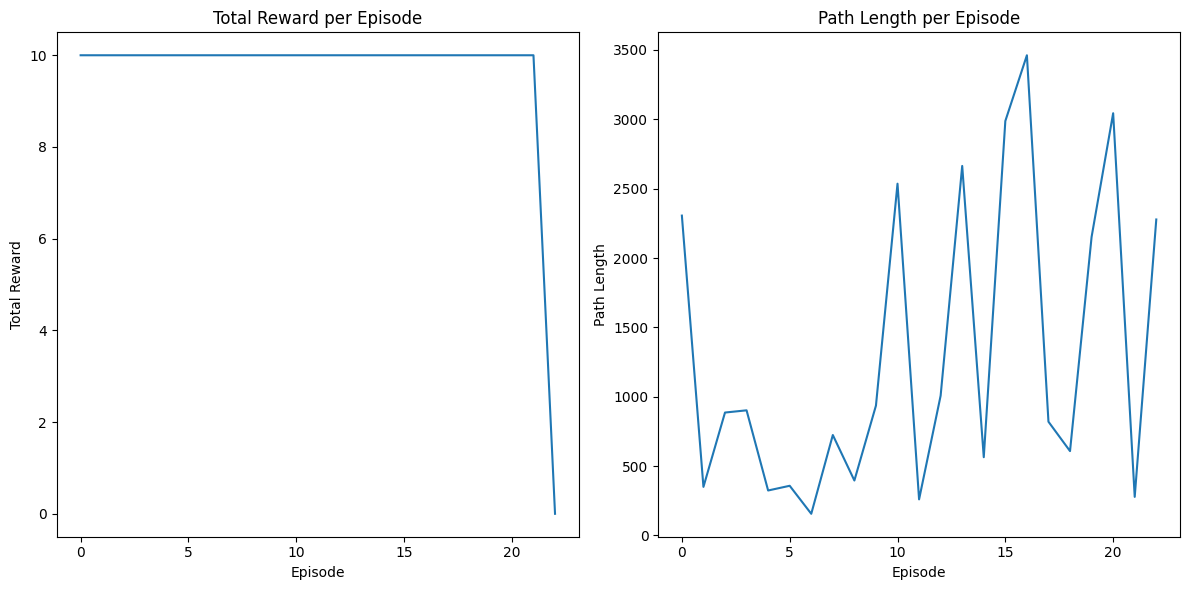

In [35]:
def run_learning_episodes_stopping(maze, agent, exploration_strategy, exploration_strategy_name, n_episodes=300, epsilon=0.01, temperature=0.2, max_steps=30000):
    """
    Runs multiple episodes of the reinforcement learning process with stopping criteria based on max steps and convergence.

    Parameters:
    - maze: The maze environment.
    - agent: The agent navigating the maze.
    - exploration_strategy: The strategy used by the agent to explore the maze.
    - exploration_strategy_name: The specific exploration strategy to implement in the cycle.
    - n_episodes: The number of episodes to run.
    - epsilon: The epsilon parameter for the e-greedy exploration strategy.
    - temperature: The temperature parameter for the Boltzmann exploration strategy.
    - max_steps: The maximum total number of steps before stopping the learning process.

    Returns:
    - episode_rewards: A list containing the total reward earned in each episode.
    - episode_lengths: A list containing the number of steps (length of the path) taken in each episode.
    """
    episode_rewards = []
    episode_lengths = []
    total_steps = 0  # Track the total number of steps taken across all episodes

    for episode in tqdm(range(n_episodes)):
        if total_steps >= max_steps:  # Check if the maximum number of steps has been reached
            print(f"Stopping criterion reached at episode {episode} with {total_steps} steps.")
            break

        total_reward = 0
        agent.reset()
        done = False
        steps = 0

        while not done:
            current_state = agent.get_state(maze)
            action = None
            if exploration_strategy_name == "random":
                action = exploration_strategy.random(agent, maze)
            elif exploration_strategy_name == "e-greedy":
                action = exploration_strategy.e_greedy(agent, maze, epsilon)
            elif exploration_strategy_name == "boltzmann":
                action = exploration_strategy.boltzmann(agent, maze, temperature)
            
            next_state, reward, done = agent.step(action, maze)

            total_reward += reward
            steps += 1
            total_steps += 1

            if total_steps >= max_steps:  # Check again in case max steps reached within the episode
                break

            # Learning logic here
            # if with_learning:
            #     learner.learn(current_state, action, reward, next_state, done)

        episode_rewards.append(total_reward)
        episode_lengths.append(steps)

        # Check for convergence
        if len(episode_lengths) >= 10 and len(set(episode_lengths[-10:])) == 1:
            print(f"Convergence criterion reached at episode {episode + 1}. Path length stable for last 15 episodes.")
            break

    return episode_rewards, episode_lengths

# Example usage
maze = Maze("./../data/toy_maze.txt")
maze.set_reward(x=9, y=9, reward=10)
maze.set_terminal(x=9, y=9)
# Create an Agent.
agent = Agent(start_x=0, start_y=0)
# Create a QTable.
states = maze.get_all_states()
actions = [Action(id) for id in ["up", "down", "left", "right"]]
q_table = QTable(states, actions)
# Create an ExplorationStrategy.
exploration_strategy = ExplorationStrategy(q_table)

# Run the cycle with stopping criteria
episode_rewards, episode_lengths = run_learning_episodes_stopping(maze, agent, exploration_strategy, 'boltzmann', 300, 0.02, 0.2)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward per Episode")

plt.subplot(1, 2, 2)
plt.plot(episode_lengths)
plt.xlabel("Episode")
plt.ylabel("Path Length")
plt.title("Path Length per Episode")
plt.tight_layout()
plt.show()

<div style="background-color:#f1be3e">

In this second implementation of our cycle, we include a stopping criterion. This criterion is based on two conditions: the maximum number of steps allowed and the convergence of the path length. The maximum number of steps is defined by the parameter `max_steps`, and the convergence criterion is met when the path length remains stable for the last 10 episodes. Max_Steps is usually set to 30000, and in the case we reach this number of steps, the learning process stops. The same occurs with the convergence criterion, if our solution is the shortest possible, there is no possible improvement, and the learning process stops after we reach this solution for the last 1o episodes. 

As you can see in the example above, the first stopping criterion is reached at episode 23, with a total of 30000 steps. At this point, the learning process is stopped. In this case, since we have not integrated learning into our process yet, 30000 steps is too few steps, and hence we do not reach the optimal solution within this number of steps. 

#### Question 4

 11%|█         | 32/300 [00:00<00:00, 444.44it/s]


Stopping criterion reached at episode 32 with 30000 steps.


  6%|▌         | 17/300 [00:00<00:02, 117.24it/s]


Stopping criterion reached at episode 17 with 30000 steps.


  7%|▋         | 22/300 [00:01<00:14, 18.73it/s]


Stopping criterion reached at episode 22 with 30000 steps.


  9%|▉         | 27/300 [00:00<00:00, 359.97it/s]


Stopping criterion reached at episode 27 with 30000 steps.


 10%|▉         | 29/300 [00:00<00:01, 213.24it/s]


Stopping criterion reached at episode 29 with 30000 steps.


  8%|▊         | 23/300 [00:01<00:13, 21.23it/s]


Stopping criterion reached at episode 23 with 30000 steps.


  7%|▋         | 22/300 [00:00<00:00, 311.63it/s]


Stopping criterion reached at episode 22 with 30000 steps.


  7%|▋         | 21/300 [00:00<00:01, 152.18it/s]


Stopping criterion reached at episode 21 with 30000 steps.


  7%|▋         | 22/300 [00:01<00:13, 21.15it/s]


Stopping criterion reached at episode 22 with 30000 steps.


  7%|▋         | 21/300 [00:00<00:00, 295.76it/s]


Stopping criterion reached at episode 21 with 30000 steps.


  5%|▌         | 16/300 [00:00<00:02, 113.47it/s]


Stopping criterion reached at episode 16 with 30000 steps.


  6%|▋         | 19/300 [00:01<00:15, 17.89it/s]


Stopping criterion reached at episode 19 with 30000 steps.


  8%|▊         | 25/300 [00:00<00:00, 337.83it/s]


Stopping criterion reached at episode 25 with 30000 steps.


  6%|▋         | 19/300 [00:00<00:02, 136.69it/s]


Stopping criterion reached at episode 19 with 30000 steps.


  7%|▋         | 22/300 [00:01<00:13, 20.60it/s]


Stopping criterion reached at episode 22 with 30000 steps.


  7%|▋         | 22/300 [00:00<00:00, 311.46it/s]


Stopping criterion reached at episode 22 with 30000 steps.


  6%|▌         | 18/300 [00:00<00:02, 135.74it/s]


Stopping criterion reached at episode 18 with 30000 steps.


  8%|▊         | 23/300 [00:01<00:12, 21.35it/s]


Stopping criterion reached at episode 23 with 30000 steps.


  8%|▊         | 25/300 [00:00<00:00, 357.07it/s]


Stopping criterion reached at episode 25 with 30000 steps.


 11%|█         | 32/300 [00:00<00:01, 237.59it/s]


Stopping criterion reached at episode 32 with 30000 steps.


  7%|▋         | 21/300 [00:01<00:14, 19.74it/s]


Stopping criterion reached at episode 21 with 30000 steps.


 10%|█         | 30/300 [00:00<00:00, 428.57it/s]


Stopping criterion reached at episode 30 with 30000 steps.


  9%|▊         | 26/300 [00:00<00:01, 194.03it/s]


Stopping criterion reached at episode 26 with 30000 steps.


  4%|▍         | 12/300 [00:01<00:24, 11.73it/s]


Stopping criterion reached at episode 12 with 30000 steps.


  8%|▊         | 24/300 [00:00<00:00, 347.82it/s]


Stopping criterion reached at episode 24 with 30000 steps.


  7%|▋         | 22/300 [00:00<00:01, 158.75it/s]

Stopping criterion reached at episode 22 with 30000 steps.



  8%|▊         | 23/300 [00:01<00:12, 21.33it/s]


Stopping criterion reached at episode 23 with 30000 steps.


  9%|▉         | 28/300 [00:00<00:00, 394.38it/s]


Stopping criterion reached at episode 28 with 30000 steps.


 10%|▉         | 29/300 [00:00<00:01, 205.64it/s]


Stopping criterion reached at episode 29 with 30000 steps.


  7%|▋         | 22/300 [00:01<00:13, 20.25it/s]


Stopping criterion reached at episode 22 with 30000 steps.


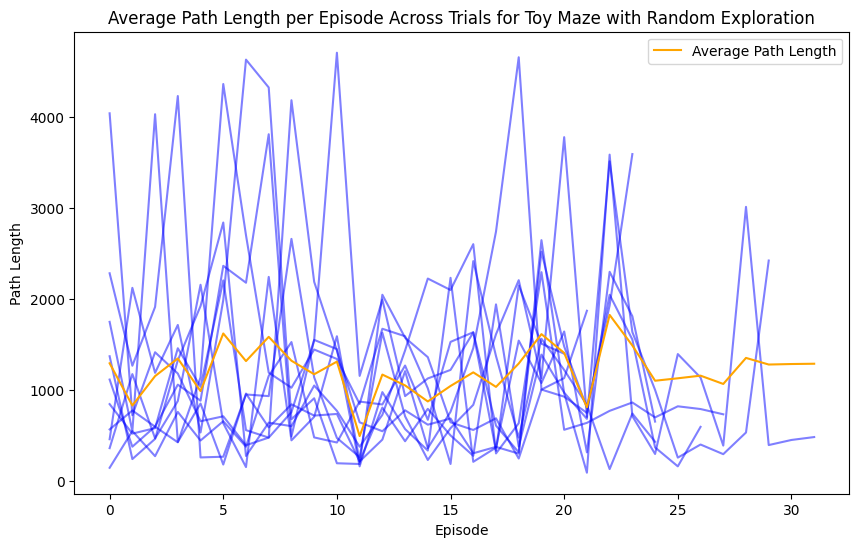

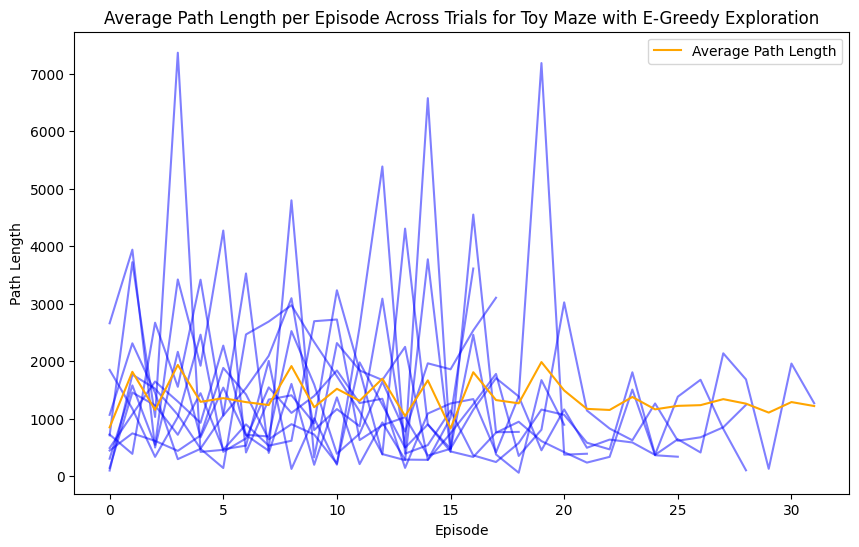

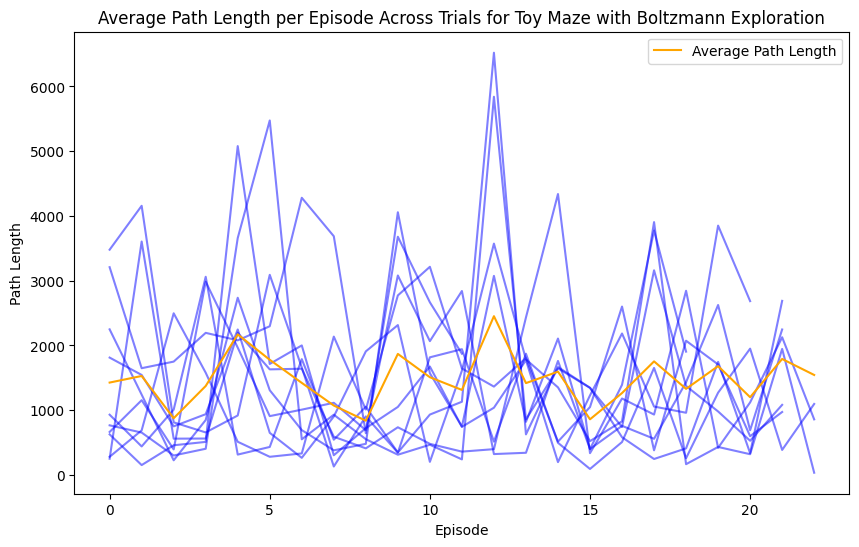

In [43]:
# Toy maze 
toy_maze = Maze("./../data/toy_maze.txt")
toy_maze.set_reward(x=9, y=9, reward=10)
toy_maze.set_terminal(x=9, y=9)
# Create an Agent.
agent = Agent(start_x=0, start_y=0)
# Create a QTable.
states_toy = toy_maze.get_all_states()
actions_toy = [Action(id) for id in ["up", "down", "left", "right"]]
q_table_toy = QTable(states, actions)
# Create an ExplorationStrategy.
exploration_strategy = ExplorationStrategy(q_table)

# Run the average of 10 different runs for 300 episodes each, with the same exploration strategy and stopping criteria
episode_lengths_random = []
episode_lengths_greedy = []
episode_lengths_boltzmann = []
for _ in range(10):
    _, episode_lengths_toy_rand = run_learning_episodes_stopping(maze, agent, exploration_strategy, 'random', 300, 0.02, 0.2)
    episode_lengths_random.append(episode_lengths_toy_rand)
    
    _, episode_lengths_toy_greedy = run_learning_episodes_stopping(maze, agent, exploration_strategy, 'e-greedy', 300, 0.02, 0.2)
    episode_lengths_greedy.append(episode_lengths_toy_greedy)
    
    _, episode_lengths_toy_boltzmann = run_learning_episodes_stopping(maze, agent, exploration_strategy, 'boltzmann', 300, 0.02, 0.2)
    episode_lengths_boltzmann.append(episode_lengths_toy_boltzmann)
    
# Padding the lengths to the same size
max_length = max(len(trial) for trial in episode_lengths_random)
padded_lengths_rand = [trial + [trial[-1]] * (max_length - len(trial)) for trial in episode_lengths_random]
average_path_lengths_random = np.mean(padded_lengths_rand, axis=0)

max_length = max(len(trial) for trial in episode_lengths_greedy)
padded_lengths_greedy = [trial + [trial[-1]] * (max_length - len(trial)) for trial in episode_lengths_greedy]
average_path_lengths_greedy = np.mean(padded_lengths_greedy, axis=0)

max_length = max(len(trial) for trial in episode_lengths_boltzmann)
padded_lengths_boltz = [trial + [trial[-1]] * (max_length - len(trial)) for trial in episode_lengths_boltzmann]
average_path_lengths_boltz = np.mean(padded_lengths_boltz, axis=0)

# Plotting each of the exploration strategies
plt.figure(figsize=(10, 6))
for trial in episode_lengths_random:
    plt.plot(trial, color='blue', alpha=0.5) 
plt.plot(average_path_lengths_random, color='orange', label='Average Path Length')  # Average in orange

plt.xlabel('Episode')
plt.ylabel('Path Length')
plt.title('Average Path Length per Episode Across Trials for Toy Maze with Random Exploration')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for trial in episode_lengths_greedy:
    plt.plot(trial, color='blue', alpha=0.5)  # Individual trials in blue
plt.plot(average_path_lengths_greedy, color='orange', label='Average Path Length')  # Average in orange

plt.xlabel('Episode')
plt.ylabel('Path Length')
plt.title('Average Path Length per Episode Across Trials for Toy Maze with E-Greedy Exploration')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for trial in episode_lengths_boltzmann:
    plt.plot(trial, color='blue', alpha=0.5)  # Individual trials in blue
plt.plot(average_path_lengths_boltz, color='orange', label='Average Path Length')  # Average in orange

plt.xlabel('Episode')
plt.ylabel('Path Length')
plt.title('Average Path Length per Episode Across Trials for Toy Maze with Boltzmann Exploration')
plt.legend()
plt.show()

 13%|█▎        | 39/300 [00:01<00:12, 20.94it/s]


Stopping criterion reached at episode 39 with 50000 steps.


 14%|█▍        | 42/300 [00:01<00:11, 22.46it/s]


Stopping criterion reached at episode 42 with 50000 steps.


 13%|█▎        | 38/300 [00:01<00:12, 20.29it/s]


Stopping criterion reached at episode 38 with 50000 steps.


 15%|█▍        | 44/300 [00:02<00:12, 21.19it/s]


Stopping criterion reached at episode 44 with 50000 steps.


 16%|█▋        | 49/300 [00:02<00:10, 24.19it/s]


Stopping criterion reached at episode 49 with 50000 steps.


 13%|█▎        | 39/300 [00:01<00:12, 21.26it/s]


Stopping criterion reached at episode 39 with 50000 steps.


 15%|█▍        | 44/300 [00:01<00:10, 24.54it/s]


Stopping criterion reached at episode 44 with 50000 steps.


 14%|█▎        | 41/300 [00:01<00:11, 22.98it/s]


Stopping criterion reached at episode 41 with 50000 steps.


 17%|█▋        | 50/300 [00:01<00:09, 27.16it/s]


Stopping criterion reached at episode 50 with 50000 steps.


 15%|█▌        | 45/300 [00:01<00:10, 24.49it/s]


Stopping criterion reached at episode 45 with 50000 steps.


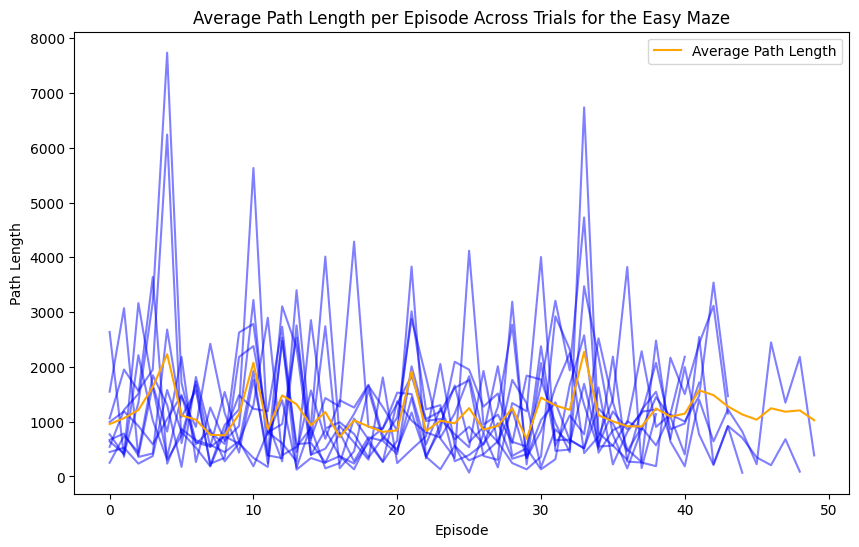

In [42]:
# Easy maze 
easy_maze = Maze("./../data/easy_maze.txt")
easy_maze.set_reward(x=24, y=14, reward=10)
easy_maze.set_terminal(x=24, y=14)
# Create an Agent.
agent = Agent(start_x=0, start_y=0)
# Create a QTable.
states_easy = easy_maze.get_all_states()
actions_easy = [Action(id) for id in ["up", "down", "left", "right"]]
q_table_easy = QTable(states, actions)
# Create an ExplorationStrategy.
exploration_strategy = ExplorationStrategy(q_table_easy)

# Run the average of 10 different runs for 300 episodes each, with the same exploration strategy and stopping criteria
episode_lengths = []
for _ in range(10):
    _, episode_lengths_easy = run_learning_episodes_stopping(maze, agent, exploration_strategy, 'boltzmann', 300, 0.02, 0.2, max_steps=50000)
    episode_lengths.append(episode_lengths_easy)
    
# Padding the lengths to the same size
max_length = max(len(trial) for trial in episode_lengths)
padded_lengths = [trial + [trial[-1]] * (max_length - len(trial)) for trial in episode_lengths]
average_path_lengths = np.mean(padded_lengths, axis=0)

# Plotting
plt.figure(figsize=(10, 6))
for trial in episode_lengths:
    plt.plot(trial, color='blue', alpha=0.5)  # Individual trials in blue

plt.plot(average_path_lengths, color='orange', label='Average Path Length')  # Average in orange

plt.xlabel('Episode')
plt.ylabel('Path Length')
plt.title('Average Path Length per Episode Across Trials for the Easy Maze')
plt.legend()
plt.show()

<div style="background-color:#f1be3e">

The two graphs represent show the average path length per episode across 10 different trials for the toy maze and the easy maze. The blue lines represent the path length for each trial, while the orange line represents the average path length across all 10 trials. 

Although the path for each of the trials is not distinguishable, the important information in the average path. Since the process is stochastic, we can see the paths for individual trials often have high variance. Whenever we change the exploration strategy, these variances do change, but not in a significant way. Overall, for both mazes the trend is the same: the path length does not decrease over time. More specifically, the average path length per episode remains within the same range, and it does not show a decreasing tendency. This works as expected, since we have not implemented any learning process yet.

#### Question 5

In [9]:
class QLearning:

    def __init__(self, q_table: QTable, params: Dict[str, float]) -> None:
        self.q_table = q_table
        self.params = params

    def learn(self, possible_actions: List[Action], state: State, action: Action,
               next_state: State, reward: int, done: bool) -> None:
        
        """
        Update the Q-value for the state-action pair using Q-learning.

        :param possible_actions: A list of possible actions from the next state
        :param state: The current state
        :param action: The action taken in the current state
        :param next_state: The resulting next state after taking the action
        :param reward: The reward received after taking the action
        :param done: Boolean indicating if next_state is terminal
        """
        alpha = self.params['lr']  # Learning rate
        gamma = self.params['gamma']  # Discount factor

        # Current Q value
        current_q = self.q_table.get_q(state, action)

        if not done:
            # Get the maximum Q-value for the next state
            max_q_next = max([self.q_table.get_q(next_state, next_action) for next_action in possible_actions])
        else:
            # If next state is terminal, then the maximum Q-value is assumed to be 0
            max_q_next = 0

        # Q-learning update rule
        updated_q = current_q + alpha * (reward + gamma * max_q_next - current_q)

        # Update the Q-table with the new Q-value
        self.q_table.set_q(state, action, updated_q)

In [10]:
class SARSA:

    def __init__(self, q_table: QTable, params: Dict[str, float]) -> None:
        self.q_table = q_table
        self.params = params
    
    def learn(self, state: State, action: Action, next_state: State, next_action: Action,
               reward: float, done: bool) -> None:
        """
        Update the Q-value for the state-action pair using SARSA.

        :param state: The current state
        :param action: The action taken in the current state
        :param next_state: The resulting next state after taking the action
        :param next_action: The next action the agent is planning to take
        :param reward: The reward received after taking the action
        :param done: Boolean indicating if next_state is terminal
        """
        alpha = self.params['lr']  # Learning rate
        gamma = self.params['gamma']  # Discount factor

        # Current Q value for the current state and action
        current_q = self.q_table.get_q(state, action)

        # SARSA update uses the Q value of the next state-action pair
        if not done:
            # If not terminal, get the Q value for the next state-action pair
            next_q = self.q_table.get_q(next_state, next_action)
        else:
            # If terminal, next Q value is 0
            next_q = 0

        # SARSA update rule
        updated_q = current_q + alpha * (reward + gamma * next_q - current_q)

        # Update the Q-table with the new Q-value
        self.q_table.set_q(state, action, updated_q)

In [13]:
def run_learning_episodes_with_learning(maze, agent, exploration_strategy, exploration_strategy_name, learner, learning_method,  n_episodes=300, epsilon=0.01, temperature=0.2, max_steps=30000):
    """
    Runs multiple episodes of the reinforcement learning process with stopping criteria based on max steps and convergence.

    Parameters:
    - maze: The maze environment.
    - agent: The agent navigating the maze.
    - exploration_strategy: The strategy used by the agent to explore the maze.
    - exploration_strategy_name: The specific exploration strategy to implement in the cycle.
    - n_episodes: The number of episodes to run.
    - epsilon: The epsilon parameter for the e-greedy exploration strategy.
    - temperature: The temperature parameter for the Boltzmann exploration strategy.
    - max_steps: The maximum total number of steps before stopping the learning process.

    Returns:
    - episode_rewards: A list containing the total reward earned in each episode.
    - episode_lengths: A list containing the number of steps (length of the path) taken in each episode.
    """
    episode_rewards = []
    episode_lengths = []
    total_steps = 0  # Track the total number of steps taken across all episodes

    for episode in tqdm(range(n_episodes)):
        if total_steps >= max_steps:  # Check if the maximum number of steps has been reached
            print(f"Stopping criterion reached at episode {episode} with {total_steps} steps.")
            break

        total_reward = 0
        agent.reset()
        done = False
        steps = 0

        while not done:
            current_state = agent.get_state(maze)
            action = None
            if exploration_strategy_name == "random":
                action = exploration_strategy.random(agent, maze)
            elif exploration_strategy_name == "e-greedy":
                action = exploration_strategy.e_greedy(agent, maze, epsilon)
            elif exploration_strategy_name == "boltzmann":
                action = exploration_strategy.boltzmann(agent, maze, temperature)
            
            next_state, reward, done = agent.step(action, maze)

            total_reward += reward
            steps += 1
            total_steps += 1

            if total_steps >= max_steps:  # Check again in case max steps reached within the episode
                break
            
            possible_actions = agent.get_valid_actions(maze)
            next_action = exploration_strategy.random(agent, maze)
            
            if learning_method == "QL":
                learner.learn(possible_actions, current_state, action, next_state, reward, done)
            elif learning_method == "SARSA":
                learner.learn(current_state, action, next_state, next_action, reward, done)

        episode_rewards.append(total_reward)
        episode_lengths.append(steps)

        # Check for convergence
        # if len(episode_lengths) >= 10 and len(set(episode_lengths[-10:])) == 1:
        #     print(f"Convergence criterion reached at episode {episode + 1}. Path length stable for last 15 episodes.")
        #     break

    return episode_rewards, episode_lengths

#### Question 6

100%|██████████| 300/300 [00:00<00:00, 4688.31it/s]


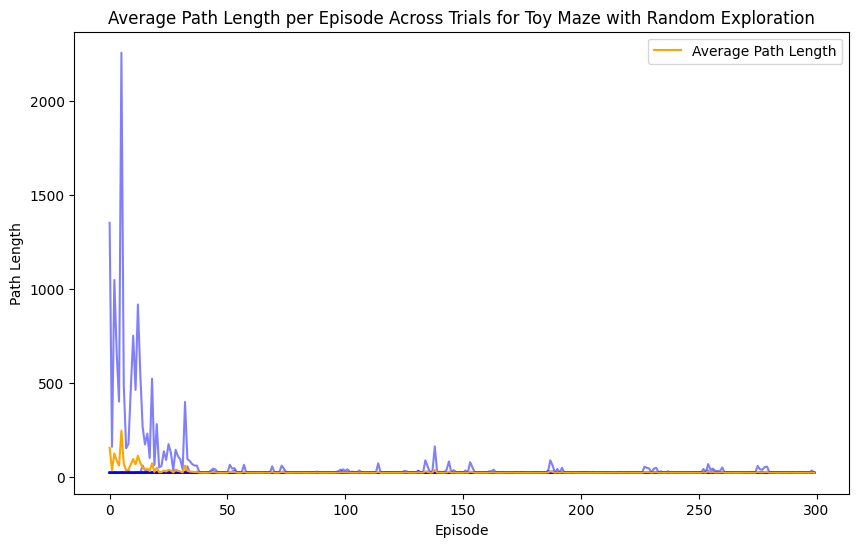

In [15]:
# Run toy maze
toy_maze = Maze("./../data/toy_maze.txt")
toy_maze.set_reward(x=9, y=9, reward=10)
toy_maze.set_terminal(x=9, y=9)
# Create an Agent.
agent = Agent(start_x=0, start_y=0)
# Create a QTable.
states_toy = toy_maze.get_all_states()
actions_toy = [Action(id) for id in ["up", "down", "left", "right"]]
q_table_toy = QTable(states_toy, actions_toy)
# Create an ExplorationStrategy.
exploration_strategy = ExplorationStrategy(q_table_toy)
learner = SARSA(q_table_toy, {"lr": 0.2, "gamma": 0.95})

# Run the average of 10 different runs for 300 episodes each, with the same exploration strategy and stopping criteria
episode_lengths_random = []
episode_lengths_greedy = []
episode_lengths_boltzmann = []
for _ in range(10):
    _, episode_lengths_toy_rand = run_learning_episodes_with_learning(toy_maze, agent, exploration_strategy, 'e-greedy', learner, "SARSA", 300, 0.01, 0.2, 30000)
    episode_lengths_random.append(episode_lengths_toy_rand)
    
# Padding the lengths to the same size
max_length = max(len(trial) for trial in episode_lengths_random)
padded_lengths_rand = [trial + [trial[-1]] * (max_length - len(trial)) for trial in episode_lengths_random]
average_path_lengths_random = np.mean(padded_lengths_rand, axis=0)


# Plotting each of the exploration strategies
plt.figure(figsize=(10, 6))
for trial in episode_lengths_random:
    plt.plot(trial, color='blue', alpha=0.5) 
plt.plot(average_path_lengths_random, color='orange', label='Average Path Length')  # Average in orange

plt.xlabel('Episode')
plt.ylabel('Path Length')
plt.title('Average Path Length per Episode Across Trials for Toy Maze with Random Exploration')
plt.legend()
plt.show()


<div style="background-color:#f1be3e">

_Put your code blocks above (if any) and write your answer here._

#### Question 7

<div style="background-color:#f1be3e">

_Write your answer here._

### 2.2 Optimization
#### Question 8

<div style="background-color:#f1be3e">

_Put your code blocks above (if any) and write your answer here._

#### Question 9

<div style="background-color:#f1be3e">

_Write your answer here._

#### Question 10

<div style="background-color:#f1be3e">

_Put your code blocks above (if any) and write your answer here._

#### Question 11

<div style="background-color:#f1be3e">

_Put your code blocks above (if any) and write your answer here._

#### Question 12

<div style="background-color:#f1be3e">

_Put your code blocks above (if any) and write your answer here._

### 2.3 Introducing More Rewards
#### Question 13

<div style="background-color:#f1be3e">

_Put your code blocks above (if any) and write your answer here._

#### Question 14

<div style="background-color:#f1be3e">

_Put your code blocks above (if any) and write your answer here._

#### Question 15

<div style="background-color:#f1be3e">

_Put your code blocks above (if any) and write your answer here._

#### Question 16

<div style="background-color:#f1be3e">

_Put your code blocks above (if any) and write your answer here._

## 3. Open Questions
### 3.1 Reflection
#### Question 17

<div style="background-color:#f1be3e">

_Write your answer here._

#### Question 18

<div style="background-color:#f1be3e">

_Write your answer here._

#### Question 19

<div style="background-color:#f1be3e">

_Write your answer here._

### 3.2 Pen and Paper
#### Question 20

<div style="background-color:#f1be3e">

_Write your answer here. You can also choose to simply include a photo of your solution._

#### Question 21

<div style="background-color:#f1be3e">

_Write your answer here. You can also choose to simply include a photo of your solution._

#### Question 22

<div style="background-color:#f1be3e">

_Write your answer here. You can also choose to simply include a photo of your solution._

### 3.3 Division of Work

#### Question 23

<div style="background-color:#f1be3e">


|          Component          |  Name A   |  Name B   |  Name C   |  Name D   |
|-----------------------------|-----------|-----------|-----------|-----------|
| Code (design)               |     A     |     B     |     C     |     D     |
| Code (implementation)       |     A     |     B     |     C     |     D     |
| Code (validation)           |     A     |     B     |     C     |     D     |
| Experiments (execution)     |     A     |     B     |     C     |     D     |
| Experiments (analysis)      |     A     |     B     |     C     |     D     |
| Experiments (visualization) |     A     |     B     |     C     |     D     |
| Report (original draft)     |     A     |     B     |     C     |     D     |
| Report (reviewing, editing) |     A     |     B     |     C     |     D     |

### References

<div style="background-color:#f1be3e">

**If you made use of any non-course resources, cite them below.**